In [2]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [4]:

features = []
labels = []
dataset_path: str = "C:\\Users\\rclendening\\researchData\\RedVox_TrainingBinary_wYTVids"
data_dir = pathlib.Path(dataset_path)
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
droneCountDict = {  # One hot encoding for labels
    "Noise": 0,
    "Drone": 1
}

dataCount = [0, 0]
train_files=[]
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        train_files.append(os.path.join(path, name))


def split_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (MFCC)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    # middle third of data
    duration = waveData.shape[0]
    startTime = np.round(duration / 3)
    endTime = np.round(duration * 2 / 3)
    waveDataSplit= waveData[int(startTime):int(endTime)]
    features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
    dataCount[droneCountDict[labelName]] += features.shape[1]
    #label= [droneDict[labelName]] * features.shape[1]
    label= [droneCountDict[labelName]]*features.shape[1]
    return features, label

def create_dataset(train_files):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if str.split(x,"\\")[6][0] == 'y': #if youtube video mark yt as true
            yt=1
        else:
            yt=0
        test_audio, sampleRate = librosa.load(x, sr=8000)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)!=0:
            x = str(x)
            label = x.split('\\')
            label = label[5]
            newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            newFeats, newLabs = split_audio(newData, label, int(sampleRate))
            features.extend(newFeats.transpose())
            newLabs=list(zip(newLabs, np.ones(len(newLabs))*yt))
            labels.extend(newLabs)

    return features, labels

def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=2048,n_mfcc=40, sr=Fs)

    return coefs

def grabTrainingSamples(n, trainingData):
    '''
    Ensures even training set by grabbing an even amount of training samples from each class.
    @param n: limiting class count
    @param trainingData: trainingData list that includes both features and labels
    @return MFCC coefficients
    '''
    droneCount=0
    noiseCount=0
    evenTrainingData = []
    evenLabelData = []
    for i in range(len(labels)):
        lab = trainingData[i][1][0]
        if lab == 1 and droneCount < n:
            droneCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
        elif lab == 0 and noiseCount < n:
            noiseCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
    return evenTrainingData, evenLabelData

Fs = 8000
numFeat = 40 #COULD BE SOURCE OF ERROR
features, labels = create_dataset(train_files)
newSet = list(zip(features, labels))
random.seed(42)
random.shuffle(newSet)  # Ensure data is mixed together
n = np.min(dataCount)  # Ensure data is symmetric (aka even amounts of training data for all classes)
# features, labels = grabTrainingSamples(n, features, labels)
#features, labels = grabTrainingSamples(n, newSet)
labels=to_categorical(np.array(labels)[:,0],num_classes=2)
trainFeatures, testFeatures, trainTargets, testTargets = train_test_split(features, labels, test_size=0.05, random_state=42) #changed to speed up training
trainTargets=np.array(trainTargets)
trainFeatures = np.array(trainFeatures)
testTargets=np.array(testTargets)
testFeatures = np.array(testFeatures)
mean = trainFeatures.mean(axis=0)
trainFeatures -= mean
std = trainFeatures.std(axis=0)
trainFeatures /= std
trainFeatures = np.reshape(trainFeatures,
                           (len(trainFeatures), numFeat, 1))
#testFeatures = np.asarray(testFeatures)
testFeatures -= mean
testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))

KeyboardInterrupt: 

In [49]:
from sklearn.utils import class_weight
weights=class_weight.compute_class_weight('balanced', classes=np.unique(trainTargets), y=np.argmax(trainTargets,axis=1))
weights=dict(enumerate(weights))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 conv_1 (Conv1D)             (None, 19, 32)            96        
                                                                 
 batch_normalization_3 (Batc  (None, 19, 32)           128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 19, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 9, 32)             3072      
                                                                 
 batch_normalization_4 (Batc  (None, 9, 32)            128       
 hNormalization)                                           

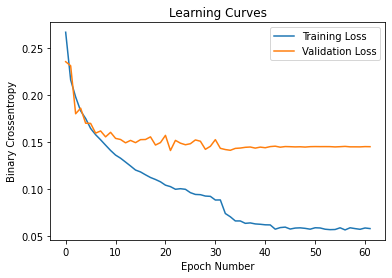

In [50]:
# Probabilistic range regression network
# def NLL(y, distr):  #Loss function
#    return -distr.log_prob(y)
# def normal_sp(params):  #Distribution function
#    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))  # Both mean and variance parameters are learnable
# inputs = Input(shape=(numFeat, 1))
# hidden = BatchNormalization()(inputs)
# hidden = Conv1D(64, 12, strides=2, use_bias=False, name='conv_1')(hidden)
# hidden = Conv1D(128, 12, strides=2, use_bias=False, name='conv_2')(hidden)
# #hidden = MaxPooling1D()(hidden)
# hidden = Dropout(0.25)(hidden)
# hidden = Flatten()(hidden)
# hidden = Dropout(0.1)(hidden)
# hidden = Flatten()(hidden)
# dist = Dense(5, activation='softmax', name='dense_2')(hidden)
inputs = Input(shape=(numFeat, 1))
hidden = Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False, name='conv_1')(inputs)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False,
                         name='conv_2')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Conv1D(filters=32, kernel_size=3, strides=2, use_bias=False,
                         name='conv_3')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Flatten()(hidden) #this is where feature extraction turns to classification
hidden = Dropout(0.1)(hidden)
hidden = Dense(864, activation='relu', name='dense_1')(hidden)  # 896, 864, 928
hidden = Dropout(0.1)(hidden)
dist = Dense(len(dataCount), activation='sigmoid', name='dense_2')(hidden)
network = Model(inputs=inputs, outputs=dist)
network.summary()
network.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
history = network.fit(trainFeatures, trainTargets,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
# if retrain:
#     call2 = ModelCheckpoint(filepath=(dirWeights + weights_save),
#                             verbose=1, monitor='val_loss', save_best_only=True)
#     reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                  verbose=1, patience=10, mode='auto')
#     early = EarlyStopping(monitor='val_loss', min_delta=1e-4,
#                           patience=40, mode='auto')
#     history = network.fit(trainFeatures, trainTargets,
#                           epochs=1000,
#                           batch_size=32,
#                           shuffle=True,
#                           validation_split=0.2,
#                           callbacks=[reduceLR, early, call2])
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Learning Curves')
#     plt.legend(['Training Loss', 'Validation Loss'])
#     plt.ylabel('Binary Crossentropy')
#     plt.xlabel('Epoch Number')
#     plt.show()
#     network.load_weights(dirWeights + weights_load, by_name=True)
# else:
#     network.load_weights(dirWeights + weights_load, by_name=True)

In [2]:
# Save network for future use
saved_network=network.to_json()
with open("model.json", "w") as json_file:
    json_file.write(saved_network)
network.save_weights('trainedMFCC.V1')

NameError: name 'network' is not defined

In [51]:
from sklearn import metrics
print()
network.evaluate(x=testFeatures,y=testTargets)
y_pred = np.argmax(network.predict(testFeatures), axis=1)
y_true = testTargets




176/176 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9471


[0.         0.10748703 0.11060044 ... 1.         1.         1.        ]
[0.         0.         0.         ... 0.94512878 0.94587533 1.        ]


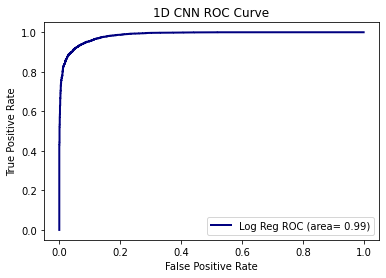

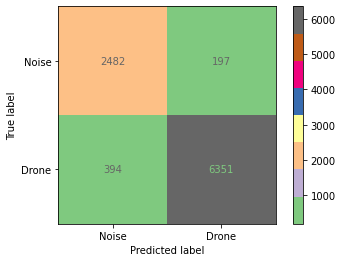

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
y_true_int = np.argmax(y_true, axis=1)
fpr,tpr,thresh= roc_curve(y_true=y_true_int, y_score=network.predict(testFeatures)[:,1])
aucVal=auc(fpr,tpr)
print(tpr)
print(fpr)
plt.plot(fpr,tpr,color='navy',label="Log Reg ROC (area= %0.2f)" %aucVal, lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("1D CNN ROC Curve")
plt.legend()
#plt.savefig('.\ROCCurve.pdf')
cm= confusion_matrix(y_true_int,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Noise','Drone'])
disp.plot(cmap='Accent')
plt.show()
#plt.savefig('.\confusionMatrixCNN.pdf')

SVM code so it has same dataset split

In [231]:
from sklearn import svm
train_classes = np.argmax(trainTargets, axis=1)
model = svm.SVC(kernel='rbf', C=100, gamma=0.01)
model.fit(trainFeatures.squeeze(),train_classes)

SVC(C=100, gamma=0.01)

In [233]:
svm_pred= model.predict(testFeatures)
svm_score=model.score(testFeatures,y_true_int)
print(svm_score)
cm= confusion_matrix(y_true_int,svm_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Noise','Drone'])
disp.plot(cmap='Accent')

ValueError: Found input variables with inconsistent numbers of samples: [14086, 6612]

This function implements majority voting scheme. It assumes all cell phones record an equal amount of data during a test, and assumes the class with the most votes is the correct class.

19
Single Phone 0.45558739255014324
Single Phone 0.5243553008595988
Single Phone 0.4297994269340974
Single Phone 0.17191977077363896
Single Phone 0.38108882521489973
Single Phone 0.36962750716332377
Single Phone 0.46418338108882523
Single Phone 0.38108882521489973
Single Phone 0.24355300859598855
Single Phone 0.3237822349570201
Single Phone 0.7879656160458453
Single Phone 0.20630372492836677
Single Phone 0.29512893982808025
Single Phone 0.3123209169054441
Single Phone 0.35816618911174786
Single Phone 0.36962750716332377
Single Phone 0.1174785100286533
Single Phone 0.7220630372492837
Single Phone 0.39255014326647564
Accuracy for drone present: 0.5616045845272206


<Figure size 432x288 with 0 Axes>

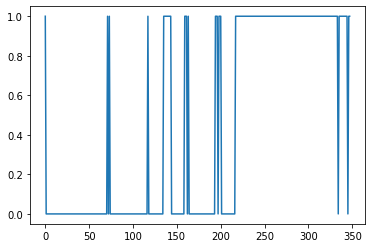

<Figure size 432x288 with 0 Axes>

In [36]:
NOISE=0
DRONE=1
usable_phones=["Phone_1-3.wav",
"Phone_2-4.wav",
"Phone_6-2.wav", #gps n/a
"Phone_6-3.wav",
"Phone_6-4.wav", #gps n/a
"Phone_6-5.wav",
"Phone_7-2.wav",
"Phone_9.wav"
]
json_file=open('trainedMFCC.V1.json', 'r')
loaded_network_json = json_file.read()
json_file.close()
loaded_network = tf.keras.models.model_from_json(loaded_network_json)
loaded_network.load_weights("trainedMFCC.V1")
loaded_network.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],)


def split_test_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    duration = waveData.shape[0]
    waveData=waveData.numpy().squeeze()
    features=MFCCCalc(waveData,Fs=8000)
    label= [droneDict[labelName]] * features.shape[1]
    return features, label

def create_test_dataset(test_files, testTime):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    features = []
    featuresLL=[]
    labels = []
    numPhones=0
    for x in test_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if len(test_audio) >= (testTime)*sampleRate and min(np.asarray(test_audio)) != 0: #ensure data actually has sound and recorded correctly
        #if x.split('\\')[7] in usable_phones:
            numPhones+=1
            x = str(x)
            #print(x.split('\\')[7])
            label = x.split('\\')[6]
            #label = label[6]
            #test_audio = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
            test_audio = test_audio[0: (testTime-1)*sampleRate]  # trim to nearest second
            #test_audio = test_audio[round(testTime/3)*sampleRate: round(testTime)*sampleRate]  # trim to nearest second
            newFeats, newLabs = split_test_audio(test_audio, "Drone", int(sampleRate))
            featuresLL.append(newFeats.transpose())
            features.extend(newFeats.transpose())
            labels.extend(newLabs)

    return features, labels, numPhones, featuresLL

def majorityVote(testFeats, testTruth, numPhones, y_pred):
    samplesPerPhone=len(testFeats)/numPhones
    i=0
    correct=0
    correctOverTime=[]
    classPrediction=[]
    droneTot,noiseTot=0,0
    for i in range(int(samplesPerPhone-1)):
        drone, noise=0,0
        for phone in range(numPhones):
            val=i+phone*int(samplesPerPhone)
            if y_pred[val].tolist()==[1,0,0,0,0]:
                drone+=1
                droneTot+=1
            elif y_pred[val].tolist()==[0,1,0,0,0]:
                noise+=1
                noiseTot+=1
        valueList=[drone, noise]
        #if np.argmax(valueList) == testTruth:
        if valueList[testTruth]/numPhones > 0.50:
            correct+=1
            prediction = testTruth
        else:
            prediction = 1
        correctOverTime.append(valueList[testTruth])
        classPrediction.append(prediction)
    totCounts=[droneTot,noiseTot]
    return correct, correctOverTime, classPrediction, totCounts
def maxValues(features):
    maxVals=[]
    for x in features:
        #maxVals.append(abs(x).max())
        #print("val:",(x[0][0]))
        maxVals.append(x[0][0]) #average power of signal
    return maxVals

def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr
def majorityVoteNew(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    prevState=5
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >0.6: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        prevState, prediction=threeBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)

    return predictedList, y_prediction

def threeBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>3:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>7:
        prevPredictState=7
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def twoBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>1:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>3:
        prevPredictState=3
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction

def fourBitPrediction(prevPredictState,prediction): #prediction need to be 1 (noise) or -1 (drone)
    if prediction == NOISE:
        predVal=-1
    else:
        predVal=1
    if prevPredictState+predVal>7:
        actualPrediction= 1
    else:
        actualPrediction = 0
    prevPredictState=prevPredictState+predVal
    if prevPredictState>15:
        prevPredictState=15
    elif prevPredictState<0:
        prevPredictState=0
    return prevPredictState, actualPrediction
testTime=90
dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\A3R6P4" #TODO
Testdata_dir = pathlib.Path(dataset_path)
phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
# oldTF= testFeatures
# oldTT =testTargets
testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
predictedList, y_prediction = majorityVoteNew(featuresLL)
print(numPhones)
correcto=0

for y in y_prediction:
    correcto=1
    for x in range(0,348):
        if y[x] == 0:
            correcto+=1
    print("Single Phone",correcto/349)
correcto=0
for x in range(0,348):
    if predictedList[x] == 0:
        correcto+=1
print("Accuracy for drone present:", correcto/349)
plt.plot(range(len(predictedList)),predictedList)
plt.figure()
#plt.plot(classPrediction)






Average Value: 0.5248033877797943
Accuracy for drone present: 0.8189655172413793
Novel method outperforms by: 56.05187319884727 %


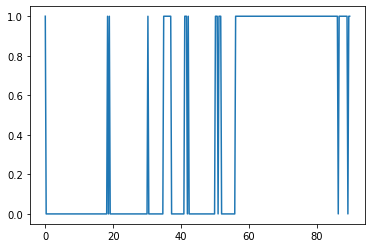

<Figure size 432x288 with 0 Axes>

In [37]:
correcto=0
sumVal=0
phone=0
start=0
stop=len(predictedList)
#y_actual=[1]*50+[0]*150+[1]*1000
#y_actual=[1]*250+[0]*500+[1]*800
#y_actual=[1]*975+[0]*500+[1]*800
y_actual=np.zeros(len(predictedList))
y_actual[int(np.round(len(predictedList)*58/testTime)):int(np.round(len(predictedList)*81/testTime))]=1
for y in y_prediction:
    phone+=1
    correcto=0
    for x in range(start,stop):
        if y[x] == y_actual[x]:
            correcto+=1
    #print("Single Phone",phone)
    #print(correcto/(stop-start))
    sumVal+= correcto/(stop-start)
print("Average Value:", sumVal/len(y_prediction))
correcto=0
for x in range(start,stop):
    if predictedList[x] == y_actual[x]:
        correcto+=1
print("Accuracy for drone present:", correcto/(stop-start))
plt.plot(np.arange(0,testTime,testTime/len(predictedList)),predictedList)
#plt.plot(predictedList)
plt.figure()
print("Novel method outperforms by:", (100*((correcto/(stop-start))-sumVal/len(y_prediction))/abs(sumVal/len(y_prediction))), "%")
#plt.plot(classPrediction)

Performance evaluation

In [41]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score
start=0
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\drone_test_truth_data_within_277m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
testTime=90
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    name=truthScenario[0]
    startDetect= truthScenario[1]
    endDetect=truthScenario[2]
    dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
    Testdata_dir = pathlib.Path(dataset_path)
    phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
    # convert to MFCC space
    testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
    # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
    fusion_prediction, y_prediction = majorityVoteNew(featuresLL)
    #
    num_frames=len(fusion_prediction) #length of one scenario in frames
    y_actual=np.zeros(num_frames)
    y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
    # Report balanced accuracy scores
    tot_indiv_score=0
    for y in y_prediction:
        indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
        #print(indiv_score)
        tot_indiv_score+= indiv_score
    tot_indiv_score=tot_indiv_score/len(y_prediction)

    #################### Score Reporting #################
    print(name)
    print("Number of used phones:",len(y_prediction))
    print("Average Value:", tot_indiv_score)
    sumAve.append(tot_indiv_score)
    fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
    novelAve.append(fusion_score)
    print("Accuracy for drone present:", fusion_score)
    performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
    outPerform.append(performanceGain)
    recall.append(recall_score(y_actual,fusion_prediction))
    precision.append(precision_score(y_actual,fusion_prediction))
    print("Recall score:", recall_score(y_actual,fusion_prediction))
    print("Precision score:", precision_score(y_actual,fusion_prediction))
    print("Novel method outperforms by:", performanceGain, "%")
    print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

A3R3P1
Number of used phones: 21
Average Value: 0.662424740010947
Accuracy for drone present: 0.896551724137931
Recall score: 0.8
Precision score: 0.8888888888888888
Novel method outperforms by: 35.34393720305721 %
_________________________
A3R3P2
Number of used phones: 19
Average Value: 0.6622807017543861
Accuracy for drone present: 0.867816091954023
Recall score: 0.875
Precision score: 0.7720588235294118
Novel method outperforms by: 31.03448275862066 %
_________________________
A3R3P3
Number of used phones: 20
Average Value: 0.6670977011494255
Accuracy for drone present: 0.8735632183908046
Recall score: 0.8
Precision score: 0.8275862068965517
Novel method outperforms by: 30.94981692870986 %
_________________________
A3R4P1
Number of used phones: 24
Average Value: 0.5162835249042146
Accuracy for drone present: 0.6063218390804598
Recall score: 0.8083333333333333
Precision score: 0.4597156398104265
Novel method outperforms by: 17.439703153988866 %
_________________________
A3R4P2
Number

Just majority vote Scoring

In [44]:
def majorityVoteAlone(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    numPhones=len(y_prediction)
    predictedList=[]
    prevState=7
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                #predictedDrone+= 1*maxValueRankArr[i][j]
                predictedDrone+= 1

        #if predictedDrone/maxVote >0.57: #adjusted from 0.6 to 0.7
        if predictedDrone/numPhones >0.5:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        prevState, prediction=fourBitPrediction(prevState, predictedVal)
        predictedList.append(prediction)

    return predictedList, y_prediction
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\drone_test_truth_data_within_277m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
precision=[]
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    name=truthScenario[0]
    startDetect= truthScenario[1]
    endDetect=truthScenario[2]
    dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
    Testdata_dir = pathlib.Path(dataset_path)
    phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
    # convert to MFCC space
    testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
    # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
    fusion_prediction, y_prediction = majorityVoteAlone(featuresLL)
    #
    num_frames=len(fusion_prediction) #length of one scenario in frames
    y_actual=np.zeros(num_frames)
    y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
    # Report balanced accuracy scores
    tot_indiv_score=0
    for y in y_prediction:
        indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
        #print(indiv_score)
        tot_indiv_score+= indiv_score
    tot_indiv_score=tot_indiv_score/len(y_prediction)

    #################### Score Reporting #################
    print(name)
    print("Number of used phones:",len(y_prediction))
    print("Average Value:", tot_indiv_score)
    sumAve.append(tot_indiv_score)
    fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
    novelAve.append(fusion_score)
    print("Accuracy for drone present:", fusion_score)
    performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
    outPerform.append(performanceGain)
    recall.append(recall_score(y_actual,fusion_prediction))
    precision.append(precision_score(y_actual,fusion_prediction))
    print("Recall score:", recall_score(y_actual,fusion_prediction))
    print("Novel method outperforms by:", performanceGain, "%")
    print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

A3R3P1
Number of used phones: 21
Average Value: 0.662424740010947
Accuracy for drone present: 0.853448275862069
Recall score: 0.7333333333333333
Novel method outperforms by: 28.837017145217914 %
_________________________
A3R3P2
Number of used phones: 19
Average Value: 0.6622807017543861
Accuracy for drone present: 0.7931034482758621
Recall score: 0.825
Novel method outperforms by: 19.75336834893809 %
_________________________
A3R3P3
Number of used phones: 20
Average Value: 0.6670977011494255
Accuracy for drone present: 0.8649425287356322
Recall score: 0.75
Novel method outperforms by: 29.657548998492317 %
_________________________
A3R4P1
Number of used phones: 24
Average Value: 0.5162835249042146
Accuracy for drone present: 0.3333333333333333
Recall score: 0.9083333333333333
Novel method outperforms by: -35.43599257884973 %
_________________________
A3R4P2
Number of used phones: 13
Average Value: 0.7714412024756853
Accuracy for drone present: 0.8390804597701149
Recall score: 0.6
Novel 

Majority Vote with Weighting

In [45]:

def majorityVoteWithWeighting(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        pred=np.argmax(loaded_network.predict(x),axis=1) #for CNN
        #pred = model.predict(x.squeeze()) #for SVM
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    prevState=5
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 1:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >0.6: #adjusted from 0.6 to 0.7
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedVal=1
            #predictedList.append(0)
        else:
            #predictedList.append(1)
            predictedVal=0
        predictedList.append(predictedVal)

    return predictedList, y_prediction
truthData= pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\drone_test_truth_data_within_277m.csv")
novelAve=[]
sumAve=[]
outPerform=[]
recall=[]
for x in range(13):
    #read scenario and truth data
    truthScenario = truthData.iloc[x]
    name=truthScenario[0]
    startDetect= truthScenario[1]
    endDetect=truthScenario[2]
    dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A3\\"+name
    Testdata_dir = pathlib.Path(dataset_path)
    phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
    # convert to MFCC space
    testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, testTime)
    # Make predictions using network, predictedList is the pipeline's predictions, whereas y_prediction is just cellphone's
    fusion_prediction, y_prediction = majorityVoteWithWeighting(featuresLL)
    #
    num_frames=len(fusion_prediction) #length of one scenario in frames
    y_actual=np.zeros(num_frames)
    y_actual[int(np.round(num_frames*startDetect/testTime)):int(np.round(num_frames*endDetect/testTime))]=1 #truth data
    # Report balanced accuracy scores
    tot_indiv_score=0
    for y in y_prediction:
        indiv_score=accuracy_score(y_true=y_actual,y_pred=y)
        #print(indiv_score)
        tot_indiv_score+= indiv_score
    tot_indiv_score=tot_indiv_score/len(y_prediction)

    #################### Score Reporting #################
    print(name)
    print("Number of used phones:",len(y_prediction))
    print("Average Value:", tot_indiv_score)
    sumAve.append(tot_indiv_score)
    fusion_score=accuracy_score(y_true=y_actual,y_pred=fusion_prediction)
    novelAve.append(fusion_score)
    print("Accuracy for drone present:", fusion_score)
    performanceGain=100*((fusion_score-tot_indiv_score)/tot_indiv_score)
    outPerform.append(performanceGain)
    recall.append(recall_score(y_actual,fusion_prediction))
    precision.append(precision_score(y_actual,fusion_prediction))
    print("Recall score:", recall_score(y_actual,fusion_prediction))
    print("Novel method outperforms by:", performanceGain, "%")
    print("_________________________")



print("Outperform",np.average(outPerform))
print("Recall",np.average(recall))
print("Precision",np.average(precision))
print(np.average(novelAve))
print(np.average(sumAve))

A3R3P1
Number of used phones: 21
Average Value: 0.662424740010947
Accuracy for drone present: 0.9051724137931034
Recall score: 0.8083333333333333
Novel method outperforms by: 36.645321214625056 %
_________________________
A3R3P2
Number of used phones: 19
Average Value: 0.6622807017543861
Accuracy for drone present: 0.882183908045977
Recall score: 0.9
Novel method outperforms by: 33.203927837405764 %
_________________________
A3R3P3
Number of used phones: 20
Average Value: 0.6670977011494255
Accuracy for drone present: 0.9051724137931034
Recall score: 0.8333333333333334
Novel method outperforms by: 35.6881326728408 %
_________________________
A3R4P1
Number of used phones: 24
Average Value: 0.5162835249042146
Accuracy for drone present: 0.646551724137931
Recall score: 0.8666666666666667
Novel method outperforms by: 25.231910946196656 %
_________________________
A3R4P2
Number of used phones: 13
Average Value: 0.7714412024756853
Accuracy for drone present: 0.9339080459770115
Recall score: 